In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [3]:
!pip install torch torchvision opencv-python scipy matplotlib scikit-learn

In [4]:
IMG_DIR = '/content/drive/MyDrive/crowd_project/processed_images'
DENSITY_DIR = '/content/drive/MyDrive/crowd_project/density_maps'

In [5]:
import os, cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [6]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [7]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, density_dir, file_list, transform=None):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        den = np.load(os.path.join(self.density_dir, img_name.replace('.jpg','.npy')))
        den = cv2.resize(den, (den.shape[1]//8, den.shape[0]//8))
        den *= 64

        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den


In [8]:
files = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]
train_files, val_files = train_test_split(files, test_size=0.17, random_state=42)

train_dataset = CrowdDataset(IMG_DIR, DENSITY_DIR, train_files, transform)
val_dataset   = CrowdDataset(IMG_DIR, DENSITY_DIR, val_files, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train:", len(train_dataset), "Validation:", len(val_dataset))

Train: 248 Validation: 52


In [9]:
cfg = {
    'frontend': [64, 64, 'M',
                 128, 128, 'M',
                 256, 256, 256, 'M',
                 512, 512, 512],
    'backend':  [512, 512, 512, 256, 128, 64]
}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers = []
    for v in cfg_list:
        if v == 'M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            conv = nn.Conv2d(in_channels, v, kernel_size=3,
                             padding=2 if dilation else 1,
                             dilation=2 if dilation else 1)
            layers += [conv, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = make_layers(cfg['frontend'], 3, dilation=False)
        self.backend  = make_layers(cfg['backend'], 512, dilation=True)
        self.output   = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [15]:
num_epochs = 50
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = "/content/drive/MyDrive/crowd_project/best_csrnet.pth"

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        pred = model(imgs)
        loss = criterion(pred, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_epoch_loss = running_train_loss / len(train_loader)
    train_losses.append(train_epoch_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, dens in val_loader:
            imgs, dens = imgs.to(device), dens.to(device)
            pred = model(imgs)
            loss = criterion(pred, dens)
            running_val_loss += loss.item()

    val_epoch_loss = running_val_loss / len(val_loader)
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}")

    # Save best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated at Epoch {epoch+1} | Saved with Val Loss: {best_val_loss:.4f}")


Epoch [1/50] Train Loss: 0.1222 | Val Loss: 0.1173
Best model updated at Epoch 1 | Saved with Val Loss: 0.1173
Epoch [2/50] Train Loss: 0.1205 | Val Loss: 0.1147
Best model updated at Epoch 2 | Saved with Val Loss: 0.1147
Epoch [3/50] Train Loss: 0.1111 | Val Loss: 0.0994
Best model updated at Epoch 3 | Saved with Val Loss: 0.0994
Epoch [4/50] Train Loss: 0.1009 | Val Loss: 0.0951
Best model updated at Epoch 4 | Saved with Val Loss: 0.0951
Epoch [5/50] Train Loss: 0.0985 | Val Loss: 0.0940
Best model updated at Epoch 5 | Saved with Val Loss: 0.0940
Epoch [6/50] Train Loss: 0.0920 | Val Loss: 0.0915
Best model updated at Epoch 6 | Saved with Val Loss: 0.0915
Epoch [7/50] Train Loss: 0.0917 | Val Loss: 0.0901
Best model updated at Epoch 7 | Saved with Val Loss: 0.0901
Epoch [8/50] Train Loss: 0.0905 | Val Loss: 0.0889
Best model updated at Epoch 8 | Saved with Val Loss: 0.0889
Epoch [9/50] Train Loss: 0.0872 | Val Loss: 0.0920
Epoch [10/50] Train Loss: 0.0857 | Val Loss: 0.1156
Epoch [11

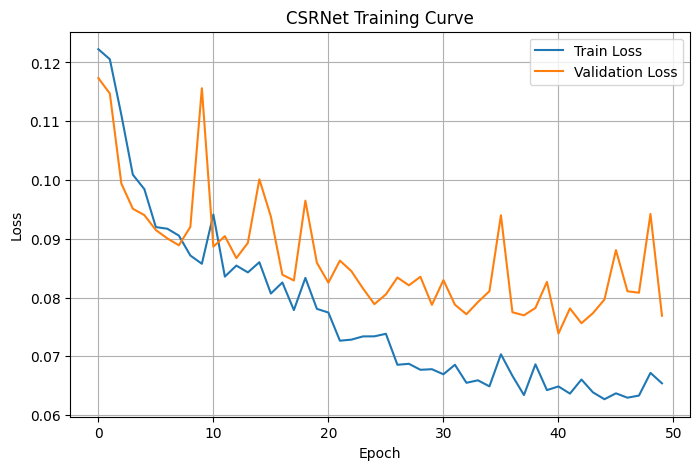

In [16]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CSRNet Training Curve")
plt.legend()
plt.grid()
plt.show()

GT Count:  877.18
Predicted: 390.42


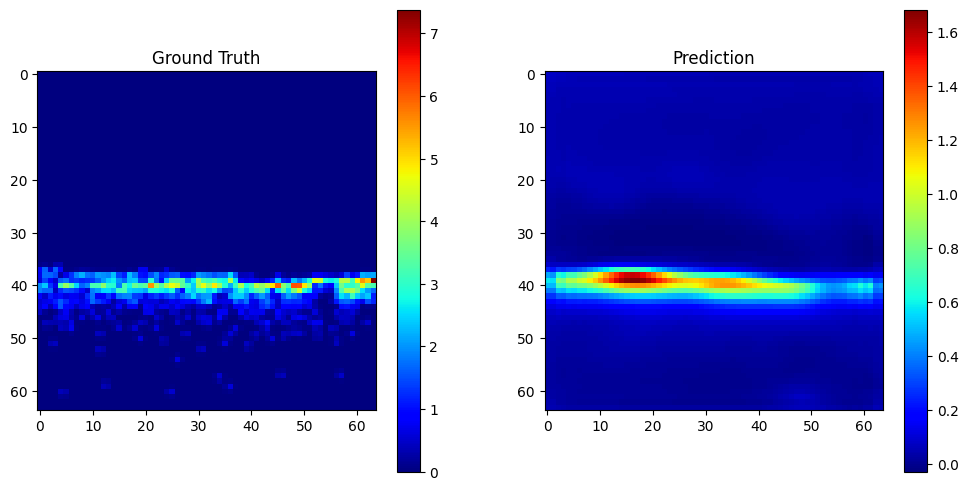

In [17]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs, dens = imgs.to(device), dens.to(device)

    pred = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pd = pred[0].cpu().numpy().squeeze()

    print(f"GT Count:  {gt.sum():.2f}")
    print(f"Predicted: {pd.sum():.2f}")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet'); plt.title("Ground Truth"); plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(pd, cmap='jet'); plt.title("Prediction"); plt.colorbar()
    plt.show()


In [19]:
torch.save(model.state_dict(), "/content/drive/MyDrive/crowd_project/csrnet_model.pth")
print("Model saved!")

Model saved!


In [11]:
num_epochs = 100
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = "/content/drive/MyDrive/crowd_project/best_csrnet.pth"

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        pred = model(imgs)
        loss = criterion(pred, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_epoch_loss = running_train_loss / len(train_loader)
    train_losses.append(train_epoch_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, dens in val_loader:
            imgs, dens = imgs.to(device), dens.to(device)
            pred = model(imgs)
            loss = criterion(pred, dens)
            running_val_loss += loss.item()

    val_epoch_loss = running_val_loss / len(val_loader)
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_epoch_loss:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}")

    # Save best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated at Epoch {epoch+1} | Saved with Val Loss: {best_val_loss:.4f}")

Epoch [1/100] Train Loss: 0.1473 | Val Loss: 0.1176
Best model updated at Epoch 1 | Saved with Val Loss: 0.1176
Epoch [2/100] Train Loss: 0.1216 | Val Loss: 0.1164
Best model updated at Epoch 2 | Saved with Val Loss: 0.1164
Epoch [3/100] Train Loss: 0.1194 | Val Loss: 0.1149
Best model updated at Epoch 3 | Saved with Val Loss: 0.1149
Epoch [4/100] Train Loss: 0.1168 | Val Loss: 0.1167
Epoch [5/100] Train Loss: 0.1153 | Val Loss: 0.1101
Best model updated at Epoch 5 | Saved with Val Loss: 0.1101
Epoch [6/100] Train Loss: 0.1060 | Val Loss: 0.0982
Best model updated at Epoch 6 | Saved with Val Loss: 0.0982
Epoch [7/100] Train Loss: 0.1013 | Val Loss: 0.0986
Epoch [8/100] Train Loss: 0.0972 | Val Loss: 0.0928
Best model updated at Epoch 8 | Saved with Val Loss: 0.0928
Epoch [9/100] Train Loss: 0.0910 | Val Loss: 0.0913
Best model updated at Epoch 9 | Saved with Val Loss: 0.0913
Epoch [10/100] Train Loss: 0.0921 | Val Loss: 0.0904
Best model updated at Epoch 10 | Saved with Val Loss: 0.090

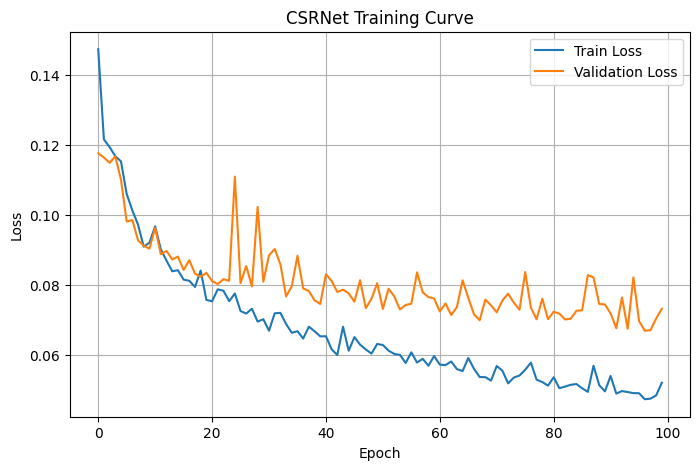

In [12]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CSRNet Training Curve")
plt.legend()
plt.grid()
plt.show()

GT Count:  877.18
Predicted: 241.28


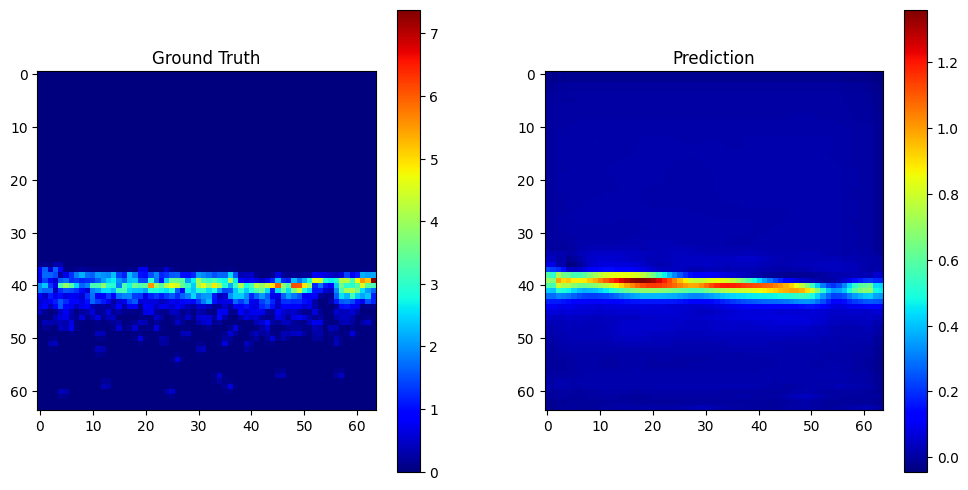

In [13]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs, dens = imgs.to(device), dens.to(device)

    pred = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pd = pred[0].cpu().numpy().squeeze()

    print(f"GT Count:  {gt.sum():.2f}")
    print(f"Predicted: {pd.sum():.2f}")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet'); plt.title("Ground Truth"); plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(pd, cmap='jet'); plt.title("Prediction"); plt.colorbar()
    plt.show()


In [14]:
TEST_IMG_DIR = "/content/drive/MyDrive/crowd_project/A_test_images"
TEST_DEN_DIR = "/content/drive/MyDrive/crowd_project/A_test_dens"

test_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith(".jpg")]

test_dataset = CrowdDataset(TEST_IMG_DIR, TEST_DEN_DIR, test_files, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Test samples:", len(test_dataset))

Test samples: 182


In [15]:
model = CSRNet().to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print("Best model loaded!")

Best model loaded!


In [31]:
mae = 0.0
mse = 0.0

with torch.no_grad():
    for imgs, dens in test_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        pred = model(imgs)

        gt_count = dens.sum().item()
        pred_count = pred.sum().item()

        mae += abs(pred_count - gt_count)
        mse += (pred_count - gt_count) ** 2

# Average over test set
mae = mae / len(test_dataset)
mse = mse / len(test_dataset)
rmse = mse ** 0.5

print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"MSE  (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

MAE  (Mean Absolute Error): 310.55
MSE  (Mean Squared Error): 152777.13
RMSE (Root Mean Squared Error): 390.87


GT Count:  56.74
Predicted: 640.55


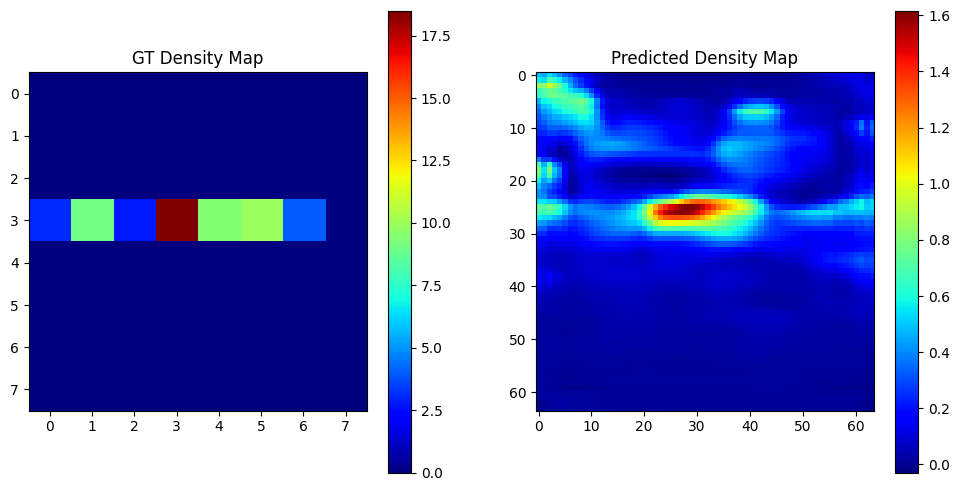

In [32]:
import matplotlib.pyplot as plt

with torch.no_grad():
    imgs, dens = next(iter(test_loader))
    imgs, dens = imgs.to(device), dens.to(device)

    pred = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pd = pred[0].cpu().numpy().squeeze()

    print(f"GT Count:  {gt.sum():.2f}")
    print(f"Predicted: {pd.sum():.2f}")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("GT Density Map")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(pd, cmap='jet')
    plt.title("Predicted Density Map")
    plt.colorbar()

    plt.show()


In [33]:
gt_counts = []
pred_counts = []

model.eval()
with torch.no_grad():
    for imgs, dens in test_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)

        pred = model(imgs)

        gt = dens.sum().item()
        pd = pred.sum().item()

        gt_counts.append(gt)
        pred_counts.append(pd)

print("Evaluation completed on all test images!")


Evaluation completed on all test images!


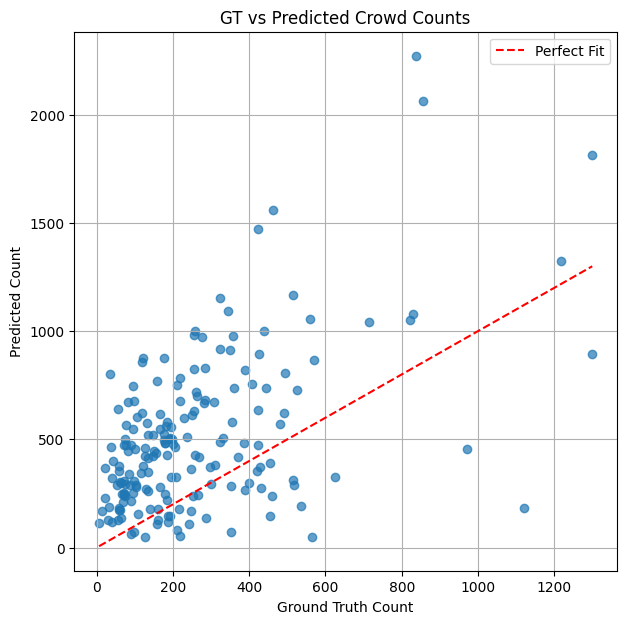

In [34]:
plt.figure(figsize=(7,7))
plt.scatter(gt_counts, pred_counts, alpha=0.7)
plt.plot([min(gt_counts), max(gt_counts)],
         [min(gt_counts), max(gt_counts)], 'r--', label="Perfect Fit")  # diagonal line
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("GT vs Predicted Crowd Counts")
plt.legend()
plt.grid(True)
plt.show()

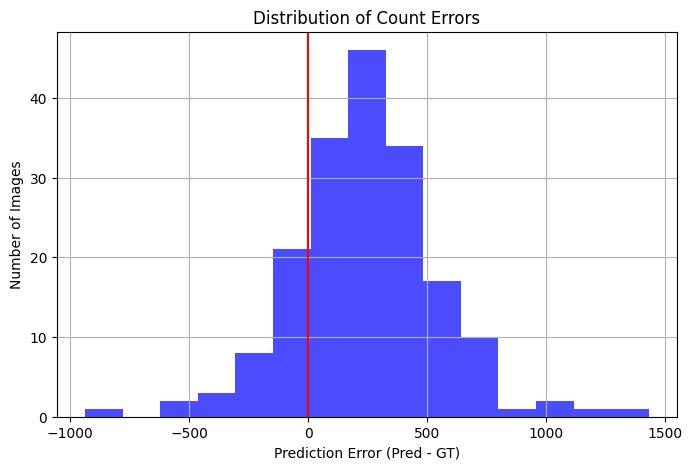

In [35]:
errors = np.array(pred_counts) - np.array(gt_counts)

plt.figure(figsize=(8,5))
plt.hist(errors, bins=15, color='blue', alpha=0.7)
plt.axvline(0, color='red')  # Zero error reference line
plt.xlabel("Prediction Error (Pred - GT)")
plt.ylabel("Number of Images")
plt.title("Distribution of Count Errors")
plt.grid(True)
plt.show()

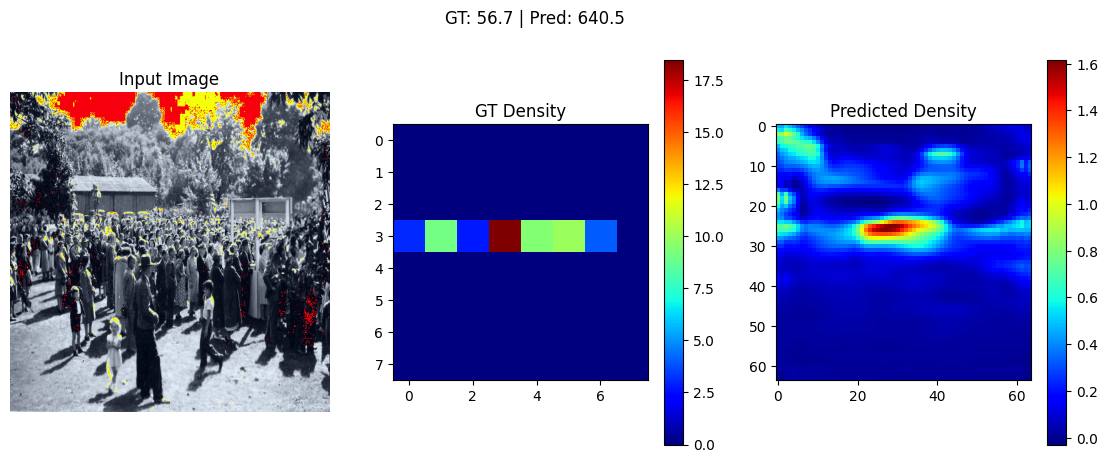

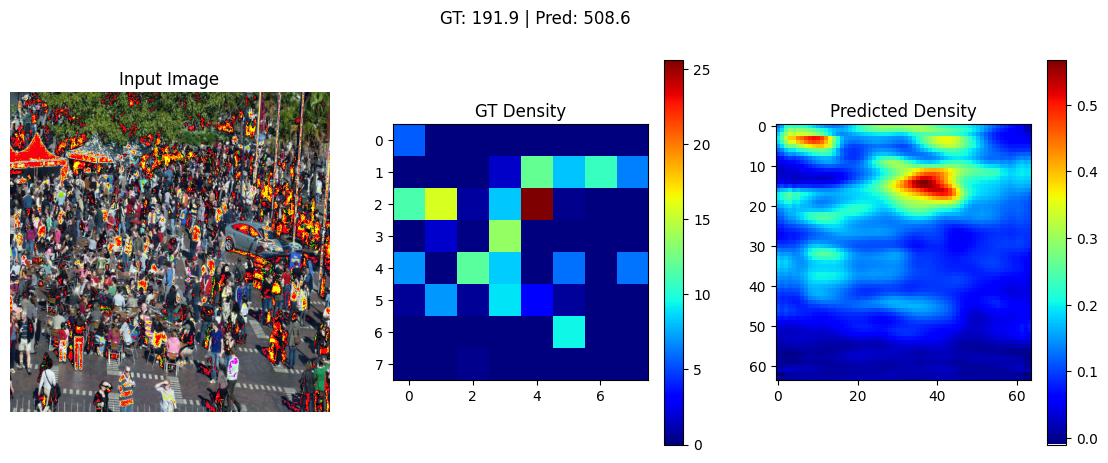

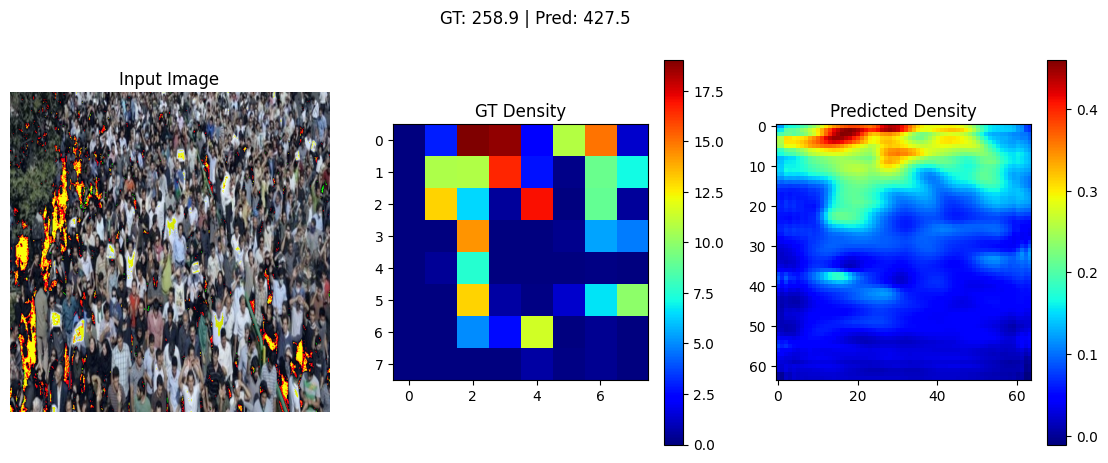

In [36]:
num_samples_to_show = 3

model.eval()
with torch.no_grad():
    for i in range(num_samples_to_show):
        imgs, dens = test_dataset[i]
        imgs = imgs.unsqueeze(0).to(device)   # add batch dimension
        dens = dens.unsqueeze(0).to(device)

        pred = model(imgs)

        img_np = imgs[0].cpu().numpy().transpose(1,2,0)
        img_np = (img_np * 0.229 + 0.456) # reverse normalization approx
        img_np = (img_np * 255).astype(np.uint8)

        gt = dens[0].cpu().numpy().squeeze()
        pd = pred[0].cpu().numpy().squeeze()

        gt_count = gt.sum()
        pd_count = pd.sum()

        plt.figure(figsize=(14,5))
        plt.suptitle(f"GT: {gt_count:.1f} | Pred: {pd_count:.1f}")

        plt.subplot(1,3,1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt, cmap='jet')
        plt.title("GT Density")
        plt.colorbar()

        plt.subplot(1,3,3)
        plt.imshow(pd, cmap='jet')
        plt.title("Predicted Density")
        plt.colorbar()

        plt.show()
